In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import itertools
import logging
import numpy as np
from collections import deque
import itertools

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [8]:
#Importing the Game Board
from Game_Board import*
max_tile=[]

In [9]:
#Converting observations in range (0,1) using log(n)/log(max) so that gradients don't vanish
def process_log(observation):
        observation = np.reshape(observation, (4, 4))
        observation_temp = np.where(observation <= 0, 1, observation) 
        processed_observation = np.log2(observation_temp)/np.log2(65536)
        return processed_observation.reshape(1,4,4)

In [10]:
def get_grids_next_step(grid):
        #Returns the next 4 states s' from the current state s
        
        grids_list = []
        
        for movement in range(4):
            grid_before = grid.copy()
            env1=Game2048Env()
            env1.set_board(grid_before)
            try:
                _= env1.move(movement) 
            except:
                pass
            grid_after =env1.get_board()
            env1.get_board()
            grids_list.append(grid_after)
            
        return grids_list

In [11]:
class DQN:
    def __init__(self,env):
        #Defining the hyperparameters for the model
        self.env=env.get_board()
        #The replay memory will be stored in a Deque
        self.memory=deque(maxlen=2000)
        self.gamma=0.90
        self.epsilon=1.0
        self.epsilon_min=0.01
        self.epsilon_decay=0.995
        self.learning_rate=0.005
        self.tau=0.125
        #We use 2 models to prevent Bootstrapping
        self.model=self.create_model()
        self.target_model=self.create_model()
        
        
    def create_model(self):
        model=Sequential()
        state_shape=4
                
        model.add(Flatten(input_shape=(4,4)))
        model.add(Dense(units=1024,activation="relu"))
        model.add(Dense(units=512,activation="relu"))
        model.add(Dense(units=256,activation="relu"))
        model.add(Dense(units=4))
        model.compile(loss="mean_squared_error",optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model
                  
    def act(self,state):
        #Epsilon value decays as model gains experience
        self.epsilon*=self.epsilon_decay
        self.epsilon=max(self.epsilon_min,self.epsilon)
        if np.random.random()<self.epsilon:
                  return np.random.randint(0,4)
        else:
            #Getting the 4 future states
            allstates=get_grids_next_step(state)
            
            res=[]
            for i in range(len(allstates)):
                if (allstates[i]==state).all():
                    res.append(0)
                else:
                    processed_state=process_log(allstates[i])
                    #max from the 4 future Q_Values is appended in res
                    res.append(np.max(self.model.predict(processed_state)))
            
            a=self.model.predict(process_log(state))
            #Final Q_Values are the sum of Q_Values of current state andfuture states
            final=np.add(a,res)
            
            return np.argmax(final)
    
    def remember(self, state, action, reward, new_state, done):
        #Replay Memory stores tuple(S, A, R, S')
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size=32
        if len(self.memory)<batch_size:
            return
        samples=random.sample(self.memory,batch_size)
        for sample in samples:
            
            state,action,reward,new_state,done=sample
            
            target=self.target_model.predict(process_log(state))
            
            
            if done:
                target[0][action]=reward
            else:
                #Bellman Equation for update
                Q_future=max(self.target_model.predict(process_log(new_state))[0])
                
                #The move which was selected, its Q_Value gets updated
                target[0][action]=reward+Q_future*self.gamma
            self.model.fit((process_log(state)),target,epochs=1,verbose=0)
                  
                  
    def target_train(self):
        weights=self.model.get_weights()
        target_weights=self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i]=weights[i]*self.tau+target_weights[i]*(1-self.tau)
        self.target_model.set_weights(target_weights)
                  
                  
    def save_model(self,fn):
        self.model.save(fn)
                  
                  


In [ ]:

def main():
    env=Game2048Env()
    gamma=0.9
    epsilon=0.95
    
    trials=1000
    trial_len=500
    dqn_agent=DQN(env=env)
    steps=[]
    
    
    
    for trial in range(trials):
        env.reset()
        cur_state=env.get_board()
        
        cur_state=cur_state.reshape(4,4)
        stepno=0
        
        for step in range(trial_len):
            stepno+=1
            
            action=dqn_agent.act(cur_state)
            
            _,reward,done,_=env.step(action)
            new_state=env.get_board()
            
            dqn_agent.remember(cur_state,action,reward,new_state,done)
            if step%10==0:
                dqn_agent.replay()
                dqn_agent.target_train()
            
            cur_agent=new_state
            
            if done:
                
                break
        
        if stepno<500:
            
            if env.highest()==2048:
                print("Completed in --",trial)
                print(env.get_board())
                max_tile.append(env.highest())

                dqn_agent.save_model("success.model")

            
            else:
                print(f"Trial number {trial} Failed to complete in 500 steps")
                print(env.get_board())
                max_tile.append(env.highest())
                if env.highest()>=512:
                    dqn_agent.save_model("trial num-{}.model".format(trial))
                    
        else:
            print(f"Failed to complete in 500 steps")
            print(env.get_board())
            max_tile.append(env.highest())

            
if __name__ == "__main__":
    main()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              17408     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 674,564
Trainable params: 674,564
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)           

2021-10-03 14:51:59.293743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-03 14:51:59.294251: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Trial number 0 Failed to complete in 500 steps
[[  2   4  16   4]
 [  4   8  64   8]
 [  8  64 128  16]
 [ 16   4   8   2]]
Trial number 1 Failed to complete in 500 steps
[[ 2  4 16  2]
 [ 8 16  4 16]
 [16 32  8  2]
 [ 2  8 32 16]]
Trial number 2 Failed to complete in 500 steps
[[  4   2   4   2]
 [ 16 128  32   4]
 [  8   2   8  64]
 [  2  16   2   4]]
Trial number 3 Failed to complete in 500 steps
[[  2   8   4   2]
 [  8   2  16   4]
 [ 16  32  64  32]
 [  2  64 128   4]]
Trial number 4 Failed to complete in 500 steps
[[ 2  8  2  8]
 [ 8 16  8 16]
 [ 2  4 16 32]
 [ 8 32 64  2]]
Trial number 5 Failed to complete in 500 steps
[[ 2  4  2  8]
 [ 4  2 16 32]
 [16  4 32 64]
 [ 

In [ ]:
trialnum=np.arange(1002)

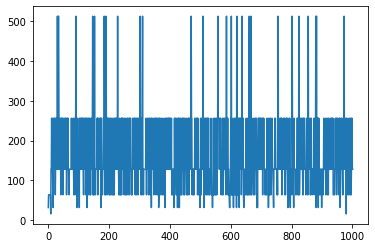

In [33]:
import matplotlib.pyplot as plt

plt.plot(trialnum,max_tile)
